# Montbrió–Pazó–Roxin (MPR) SDE — Simulation & Likelihood-Free Inference<br>
Minimal example using Numba-accelerated `MPR_sde` from `vbi`.<br>
Sections are short and documented so you can convert to a notebook easily.<br>
External APIs remain unchanged; only our helper functions are refactored.

<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/mpr_sde_numba_cde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install VBI package in Google Colab (lightweight, CPU-only version)
print("Setting up VBI for Google Colab...")

# Skip C++ compilation for faster installation in Colab
%env SKIP_CPP=1

print("Environment configured.")

In [ ]:
# Install the package
# !pip install vbi

In [ ]:
print("VBI package installed successfully! Ready to proceed.")

#### Imports & Global Config

In [70]:
import os
import warnings
from copy import deepcopy
import multiprocessing as mp
from multiprocessing import Pool

In [71]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [72]:
import vbi
from vbi.models.numba.mpr import MPR_sde

In [73]:
warnings.simplefilter("ignore")
print(f"vbi version: {vbi.__version__}")

vbi version: 0.2.2


In [74]:
SEED = 42
np.random.seed(SEED)

In [75]:
LABELSIZE = 10
plt.rcParams["axes.labelsize"] = LABELSIZE
plt.rcParams["xtick.labelsize"] = LABELSIZE
plt.rcParams["ytick.labelsize"] = LABELSIZE

In [76]:
OUT_DIR = "output/mpr_sde_numba_cde_/"
os.makedirs(OUT_DIR, exist_ok=True)

If False: (re)generate data; if True: load from disk when available.

In [77]:
LOAD_DATA = True

#### Simulation Helpers

In [78]:
def simulate_once(G_value: float, params: dict):
    """
    Run one MPR_sde simulation for a given global coupling G_value.
    Returns
    -------
    If RECORD_RV:
        rv_t, r, v, bold_t, bold_d
    else:
        bold_t, bold_d
    """
    par = deepcopy(params)
    sde = MPR_sde(par)
    control = {"G": G_value}
    data = sde.run(control)
    rv_t = data["rv_t"]
    rv_d = data["rv_d"]
    bold_t = data["bold_t"]
    bold_d = data["bold_d"]
    if par["RECORD_RV"]:
        n_nodes = par["weights"].shape[0]
        r = rv_d[:, :n_nodes]
        v = rv_d[:, n_nodes:]
        return rv_t, r, v, bold_t, bold_d
    else:
        return bold_t, bold_d

In [79]:
def simulate_batch(params: dict, controls, n_workers: int = 1):
    """
    Run a batch of simulations in parallel with a progress bar.
    Parameters
    ----------
    params : dict
        Parameter dictionary for MPR_sde.
    controls : iterable
        Iterable of control values (e.g., G grid).
    n_workers : int
        Number of parallel workers.
    Returns
    -------
    list
        List of results from `simulate_once`.
    """
    n = len(controls)
    def _update(_):
        pbar.update()
    with Pool(processes=n_workers) as pool:
        with tqdm(total=n, desc="Running simulations") as pbar:
            async_results = [
                pool.apply_async(
                    simulate_once, args=(controls[i], params), callback=_update
                )
                for i in range(n)
            ]
            results = [res.get() for res in async_results]
    return results

In [80]:
def plot_timeseries(rv_t, r, v, bold_t, bold_d, step: int = 10):
    """
    Quick-look plots for state variables (r, v) and BOLD.
    Parameters
    ----------
    rv_t, bold_t : 1D arrays
        Time vectors (ms for rv_t, ms for bold_t).
    r, v, bold_d : arrays
        State variables and BOLD data.
    step : int
        Decimation for line density when plotting r, v.
    """
    fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
    ax[0].plot(rv_t[::step], r[::step, :], lw=0.1)
    ax[1].plot(rv_t[::step], v[::step, :], lw=0.1)
    ax[2].plot(bold_t, bold_d, lw=0.1)
    ax[0].set_ylabel("r")
    ax[1].set_ylabel("v")
    ax[2].set_ylabel("BOLD")
    ax[2].set_xlabel("Time [ms]")
    ax[0].margins(x=0.01)
    plt.tight_layout()

#### Toy Network Warm-Up (Complete Graph, n=6)

In [81]:
n_nodes = 6
W = nx.to_numpy_array(nx.complete_graph(n_nodes))

In [82]:
params = {
    "G": 0.01,
    "weights": W,
    "t_end": 10_000,
    "t_cut": 1_000,
    "dt": 0.01,
    "tau": 1.0,
    "eta": np.array([-4.6]),
    "rv_decimate": 10,      # in time steps
    "noise_amp": 0.037,
    "tr": 300.0,            # ms
    "seed": SEED,
    "RECORD_BOLD": True,
    "RECORD_RV": True,
}

Warm-up run (sanity check)

In [83]:
rv_t, r, v, bold_t, bold_d = simulate_once(0.33, params)
print("NaNs in r:", np.isnan(r).sum())

NaNs in r: 0


Longer run for visualization

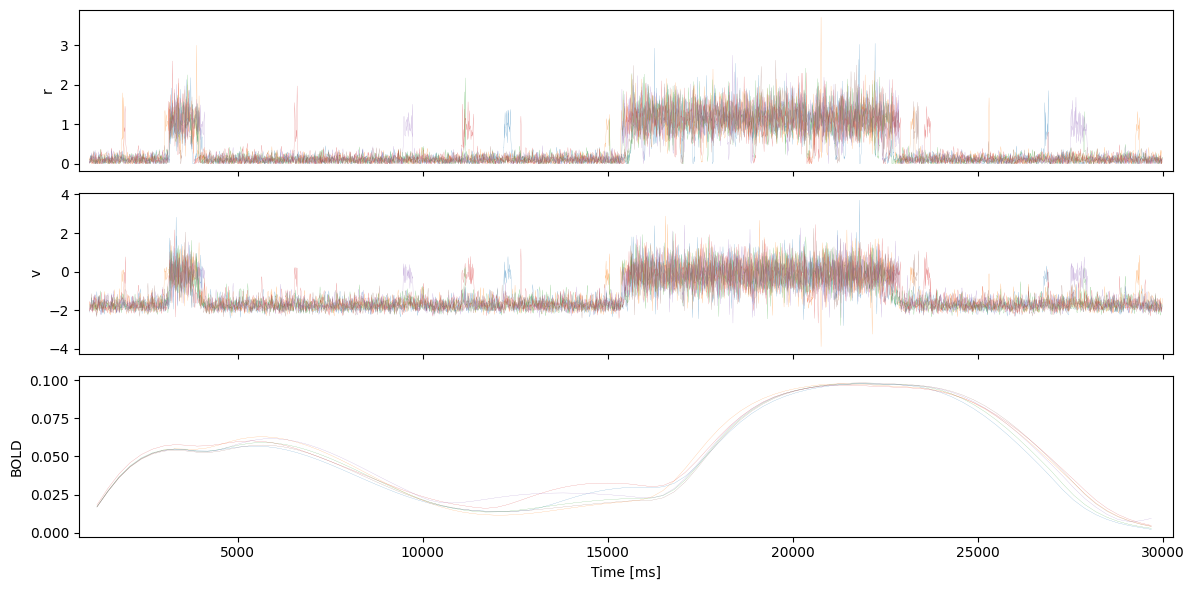

In [84]:
params["t_end"] = 30_000
G0 = 0.33
rv_t, r, v, bold_t, bold_d = simulate_once(G0, params)
plot_timeseries(rv_t, r, v, bold_t, bold_d)

Check time steps

In [85]:
print(np.diff(rv_t)[:2], np.diff(bold_t[:2]), rv_t[0], rv_t[1], rv_t[-1])

[1. 1.] [300.] 1000.0 1001.0 29999.0


#### Parameter Sweep over G (Multiprocessing)

In [86]:
G_grid = np.linspace(0.30, 0.35, 4, endpoint=True)
sweep_results = simulate_batch(params, G_grid, n_workers=4)
print("Num sweeps, shape of one result:", len(sweep_results), len(sweep_results[0]))
# Example plotting:
# for i in range(len(G_grid)):
#     rv_t, r, v, bold_t, bold_d = sweep_results[i]
#     plot_timeseries(rv_t, r, v, bold_t, bold_d)

Running simulations: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

Num sweeps, shape of one result: 4 5


#### Whole-Connectome Setup

In [87]:
D = vbi.LoadSample(nn=84)
W_full = D.get_weights()
n_full = W_full.shape[0]
print(f"number of nodes: {n_full}")

number of nodes: 84


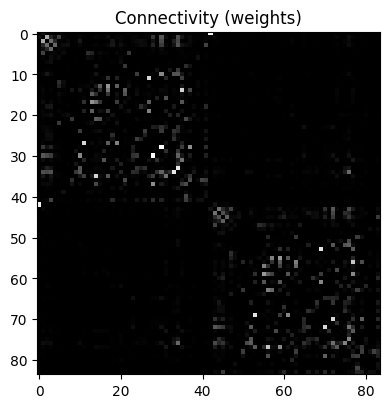

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4.5))
ax.imshow(W_full, cmap="gray", vmin=0, vmax=1)
ax.set_title("Connectivity (weights)")
plt.tight_layout()

In [89]:
TR = 300.0                 # ms
fs = 1 / (TR / 1000.0)     # Hz
t_cut_sec = 20             # for labeling only
theta_true = 0.7

In [90]:
par_obs = {
    "G": theta_true,
    "weights": W_full,
    "dt": 0.01,
    "t_cut": 20_000,        # ms
    "t_end": 100_000,       # ms
    "tr": TR,
    "rv_decimate": 10,
    "seed": SEED,
    "RECORD_RV": True,
    "RECORD_BOLD": True,
}

Generate or load observation

In [91]:
if not LOAD_DATA:
    obj = MPR_sde(par_obs)
    sol = obj.run()
    rv_d = sol["rv_d"]
    rv_t = sol["rv_t"] / 1000.0  # s
    bold_d = sol["bold_d"]
    bold_t = sol["bold_t"] / 1000.0  # s
    print("NaNs:", np.isnan(bold_d).sum(), np.isnan(rv_d).sum())
    print(f"rv_t.shape={rv_t.shape}, rv_d.shape={rv_d.shape}")
    print(f"bold_d.shape={bold_d.shape}, bold_t.shape={bold_t.shape}")
    np.savez(
        OUT_DIR + "observation.npz",
        xo=None,  # placeholder; will fill after feature extraction
        theta=theta_true,
        bold_t=bold_t,
        bold_d=bold_d,
        rv_t=rv_t,
        rv_d=rv_d,
    )
else:
    obs = np.load(OUT_DIR + "observation.npz")
    bold_d = obs["bold_d"]
    bold_t = obs["bold_t"]
    rv_d = obs["rv_d"]
    rv_t = obs["rv_t"]

#### Visualize Observation: States & BOLD

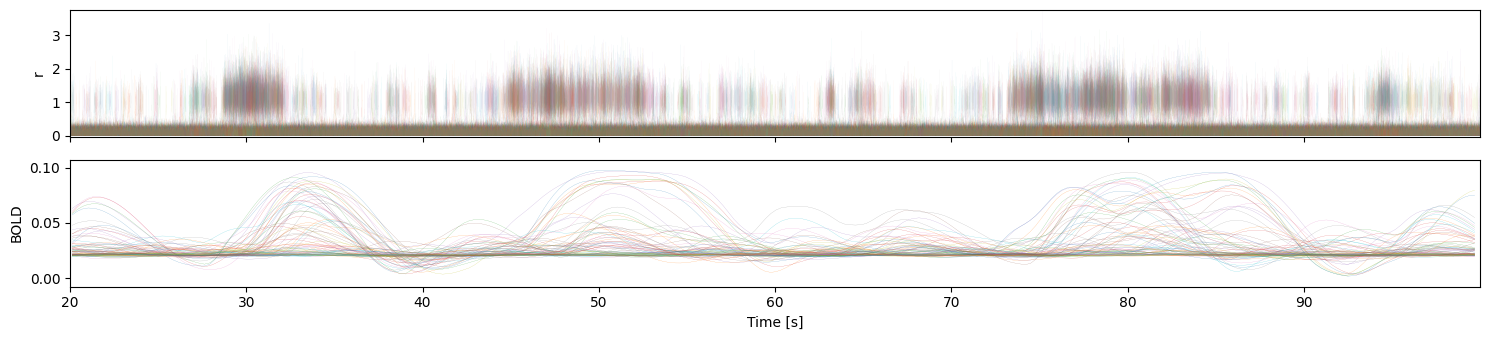

In [92]:
fig, ax = plt.subplots(2, figsize=(15, 3.5), sharex=True)
ax[0].plot(rv_t, rv_d[:, :n_full], lw=0.1, alpha=0.1)
ax[1].plot(bold_t, bold_d[:, :], lw=0.1)
ax[0].set_ylabel("r")
ax[1].set_ylabel("BOLD")
ax[1].set_xlabel("Time [s]")
ax[0].margins(0, 0.01)
ax[1].margins(0, 0.1)
plt.tight_layout()
plt.show()

#### Feature Extraction (Connectivity Domain)

In [93]:
from vbi import (
    get_features_by_domain,
    get_features_by_given_names,
    report_cfg,
    extract_features,
)

In [94]:
feat_cfg = get_features_by_domain("connectivity")
feat_cfg = get_features_by_given_names(feat_cfg, ["fcd_stat"])
report_cfg(feat_cfg)

Selected features:
------------------
■ Domain: connectivity
 ▢ Function:  fcd_stat
   ▫ description:  Extracts features from dynamic functional connectivity (FCD)
   ▫ function   :  vbi.feature_extraction.features.fcd_stat
   ▫ parameters :  {'TR': 1.0, 'win_len': 30, 'positive': False, 'eigenvalues': True, 'masks': None, 'verbose': False, 'pca_num_components': 3, 'quantiles': [0.05, 0.25, 0.5, 0.75, 0.95], 'k': None, 'features': ['sum', 'max', 'min', 'mean', 'std', 'skew', 'kurtosis']}
   ▫ tag        :  ['fmri', 'eeg', 'meg']
   ▫ use        :  yes


In [95]:
df_obs = extract_features(
    [bold_d.T],
    fs,
    feat_cfg,
    n_workers=mp.cpu_count(),
    output_type="dataframe",
    verbose=False,
)

Keep a compact feature set

In [96]:
df_obs = df_obs[["fcd_full_sum", "fcd_full_ut_std"]]
x_obs = df_obs.values
df_obs.head(1)

,fcd_full_sum,fcd_full_ut_std
0,8933.09375,0.054202


Update observation file with features

In [97]:
obs_path = OUT_DIR + "observation.npz"
obs_file = np.load(obs_path)
np.savez(
    obs_path,
    xo=x_obs,
    theta=obs_file["theta"],
    bold_t=obs_file["bold_t"],
    bold_d=obs_file["bold_d"],
    rv_t=obs_file["rv_t"],
    rv_d=obs_file["rv_d"],
)

#### Prior & Training Data Generation

In [98]:
from vbi.utils import BoxUniform

In [99]:
num_sim = 200
G_min, G_max = 0.0, 1.0

In [100]:
prior_min = [G_min]
prior_max = [G_max]
prior = BoxUniform(low=prior_min, high=prior_max)
theta = prior.sample((num_sim,), seed=SEED)

In [101]:
par_train = {
    "G": 0.506,               # initial G; per-run control overrides this
    "weights": W_full,
    "dt": 0.01,
    "t_cut": 20_000,
    "t_end": 100_000,         # ms
    "tr": TR,
    "rv_decimate": 10,
    "seed": SEED,
    "RECORD_RV": False,
    "RECORD_BOLD": True,
}

In [102]:
if not LOAD_DATA:
    sim_results = simulate_batch(par_train, theta.squeeze(), n_workers=mp.cpu_count())
    # Each result: (bold_t, bold_d) because RECORD_RV=False
    bold_list = [res[1].T for res in sim_results]
    bold_arr = np.array(bold_list)
    print("bold_arr.shape:", bold_arr.shape)
    np.savez(OUT_DIR + "bolds.npz", bolds=bold_arr, theta=theta)
else:
    bold_arr = np.load(OUT_DIR + "bolds.npz")["bolds"]

In [103]:
df_train = extract_features(
    bold_arr, fs, feat_cfg, n_workers=mp.cpu_count(), output_type="dataframe", verbose=True
)
X = df_train[["fcd_full_sum", "fcd_full_ut_std"]].values
np.savez(OUT_DIR + "training_data.npz", theta=theta, X=X)

100%|██████████| 200/200 [00:02<00:00, 87.44it/s]


#### Train Density Estimator (MAF) & Posterior Summary

In [104]:
from vbi.utils import posterior_shrinkage_numpy, posterior_zscore_numpy
from vbi.cde import MAFEstimator
import autograd.numpy as anp

In [105]:
rng = anp.random.RandomState(SEED)
maf = MAFEstimator(n_flows=4, hidden_units=64)
maf.train(theta.astype(np.float32), X.astype(np.float32), n_iter=1000, learning_rate=2e-4)

Inferred dimensions: param_dim=1, feature_dim=2


Training:  53%|█████▎    | 532/1000 [00:09<00:08, 56.57it/s, patience=20/20, train=1.0553, val=1.0634]


In [106]:
samples = maf.sample(x_obs, n_samples=5000, rng=rng)[0]
shrinkage = posterior_shrinkage_numpy(theta, samples)
zscore = posterior_zscore_numpy(theta_true, samples)

In [107]:
print("True parameters:     ", theta_true)
print("MAF mean estimate:   ", np.mean(samples, axis=0))
print("Posterior shrinkage: ", np.array2string(shrinkage, precision=3, separator=", "))
print("Posterior z-score:   ", np.array2string(zscore, precision=3, separator=", "))

True parameters:      0.7
MAF mean estimate:    [0.73598164]
Posterior shrinkage:  [0.951]
Posterior z-score:    [0.553]


In [108]:
np.savez(OUT_DIR + "samples.npz", samples=samples, xo=x_obs, theta_true=theta_true)

#### Feature–Parameter Scatter (Quick Diagnostic)

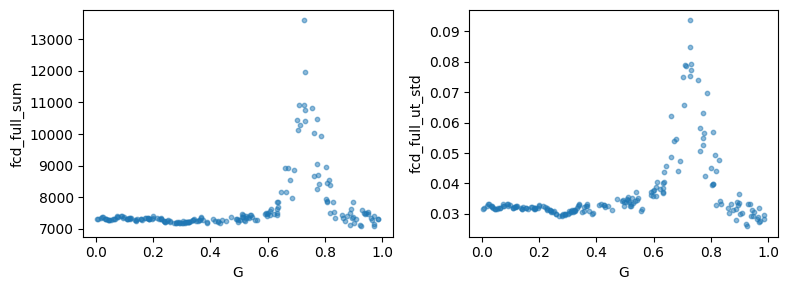

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].scatter(theta, X[:, 0], s=10, alpha=0.5)
ax[0].set_xlabel("G")
ax[0].set_ylabel("fcd_full_sum")
ax[1].scatter(theta, X[:, 1], s=10, alpha=0.5)
ax[1].set_xlabel("G")
ax[1].set_ylabel("fcd_full_ut_std")
plt.tight_layout()

#### FC / FCD Visualization for Observation

In [110]:
from vbi.feature_extraction.features_utils import get_fc, get_fcd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [111]:
obs = np.load(OUT_DIR + "observation.npz")
bold_d = obs["bold_d"]   # (T, N)
bold_t = obs["bold_t"]   # (T,)

In [112]:
FC = get_fc(bold_d.T)["full"]
FCD = get_fcd(bold_d.T, win_len=25)["full"]

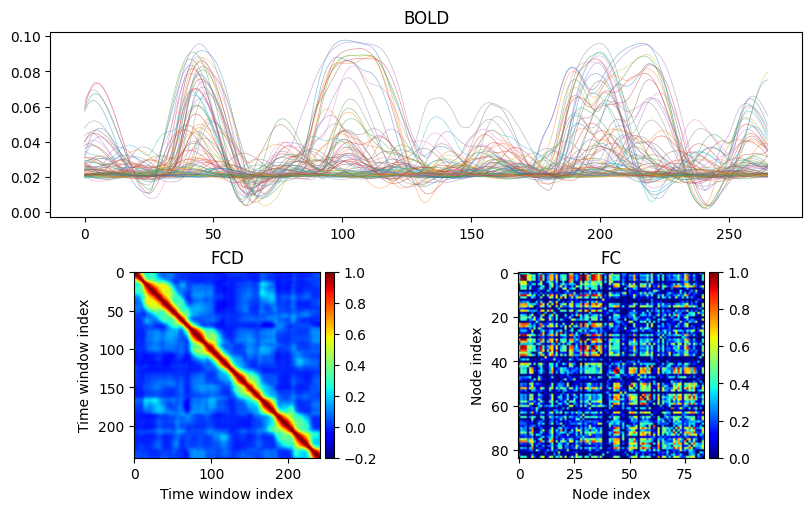

In [113]:
mosaic = """
AA
BC
"""
fig = plt.figure(constrained_layout=True, figsize=(8, 5))
axd = fig.subplot_mosaic(mosaic)
axd["A"].plot(bold_d, lw=0.5, alpha=0.5)
im0 = axd["B"].imshow(FCD, cmap="jet", vmin=-0.2, vmax=1)
im1 = axd["C"].imshow(FC,  cmap="jet", vmin=0,    vmax=1)
for key, im in [("B", im0), ("C", im1)]:
    div = make_axes_locatable(axd[key])
    cax = div.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
axd["A"].set_title("BOLD")
axd["B"].set_title("FCD")
axd["B"].set_xlabel("Time window index")
axd["B"].set_ylabel("Time window index")
axd["C"].set_title("FC")
axd["C"].set_xlabel("Node index")
axd["C"].set_ylabel("Node index")
plt.show()

#### Posterior Plot (Pairplot)

In [114]:
from vbi.plot import pairplot_numpy

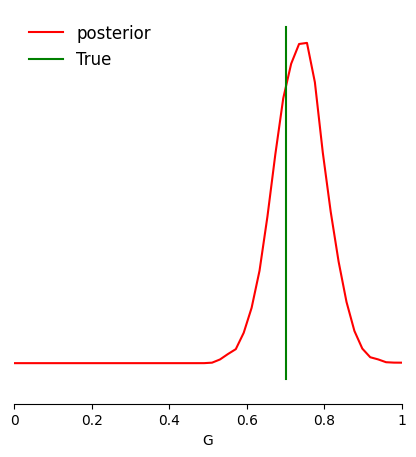

In [115]:
limits = [[lo, hi] for lo, hi in zip(prior_min, prior_max)]
fig, ax = pairplot_numpy(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=np.array([theta_true]).reshape(1, -1),
    labels=["G"],
    offdiag="kde",
    diag="kde",
    fig_kwargs=dict(points_offdiag=dict(marker="*", markersize=10), points_colors=["g"]),
    diag_kwargs={"mpl_kwargs": {"color": "r"}},
)
plt.legend(["posterior", "True"], loc="upper left", fontsize=12, frameon=False)
fig.savefig(OUT_DIR + "/G.png", dpi=150)